# Implementing ARIMA Model

***

In [17]:
# load modules
import statsmodels.tsa.arima.model as sm
import statsmodels.tools.eval_measures as em
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# import weekly finance series, skipping column names
ts = np.genfromtxt("../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

In [4]:
# store the total number of series and the number of time periods
num_series, num_t = ts.shape

***

## Model Implementation

We will follow the step-by-step process provided in **Forecasting: Principles and Practice**.

#### 1. Plot the data

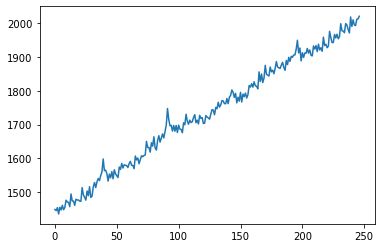

In [7]:
# plot a random series we will use for model testing
plt.plot(ts[100,:])

#### 2. Transform with BoxCox (if necessary)

In [13]:
mod = sm.ARIMA(ts[100,:])

In [14]:
res = mod.fit()

In [15]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  247
Model:                          ARIMA   Log Likelihood               -1611.290
Date:                Tue, 08 Feb 2022   AIC                           3226.581
Time:                        15:18:29   BIC                           3233.600
Sample:                             0   HQIC                          3229.407
                                - 247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1732.1369     10.511    164.786      0.000    1711.535    1752.739
sigma2      2.712e+04   3756.945      7.219      0.000    1.98e+04    3.45e+04
===================================================================================
Ljung-Box (L1) (Q):                 240.97   Jarque-Bera (JB):                13.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.08
Prob(H) (two-sided):                  0.76   Kurtosis:                         1.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

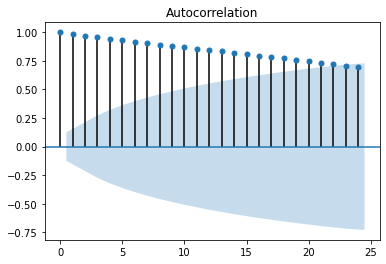

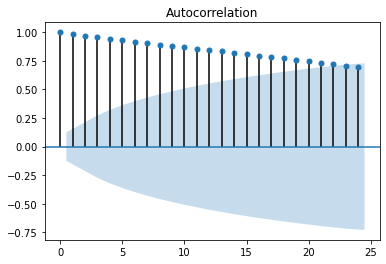

In [18]:
plot_acf(res.resid)